In [1147]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii
import scipy.ndimage as ndimage
import math
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale
import time

In [1077]:
def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = np.empty((angles, radii), dtype='float64')
    theta.T[:] = np.linspace(0, np.pi, angles, endpoint=False) * -1.0
    # d = radii
    d = np.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (math.log10(d) / (radii))
    radius = np.empty_like(theta)
    radius[:] = np.power(log_base,
                            np.arange(radii, dtype='float64')) - 1.0
    x = radius * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


In [1078]:
def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    x = np.outer(
        np.cos(np.linspace(-math.pi/2., math.pi/2., shape[0])),
        np.cos(np.linspace(-math.pi/2., math.pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)



float32


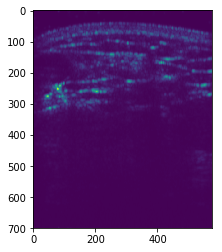

In [1230]:
data_temp = np.load('wrist_data.npy').astype(np.float32)
data_temp = np.swapaxes(data_temp, 1,2)
if data_temp.shape[1] % 2 == 1:
    data_temp = data_temp[:,:-1,:]
if data_temp.shape[2] % 2 == 1:
    data_temp = data_temp[:,:,:-1]
print(data_temp.dtype)
max_val = np.amax(data_temp)
plt.imshow(data_temp[0])



(25, 576, 576)


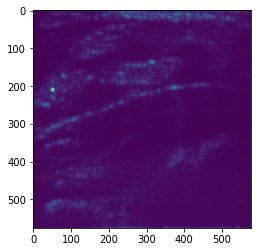

In [1375]:
noah_wrist = np.load('noah_wrist_manual.npy').astype(np.float32)
# noah_wrist = np.swapaxes(noah_wrist, 1,2)
if noah_wrist.shape[1] % 2 == 1:
    noah_wrist = noah_wrist[:,:-1,:]
if noah_wrist.shape[2] % 2 == 1:
    noah_wrist = noah_wrist[:,:,:-1]
print(noah_wrist.shape)
noah_max_val = np.amax(noah_wrist)
plt.imshow(noah_wrist[6])

In [1384]:
def estimate_rotation(im_0, im_1, clip_top = None, conv_size = None, gauss_filter = None):
    '''finds counter-clockwise rotation between im_0 and im_1'''
    
    if clip_top:
        im_0  = im_0[clip_top:,:]
        im_1  = im_1[clip_top:,:]
    
    if conv_size:
        im_0 = ndimage.morphology.grey_opening(im_0, size =(conv_size, conv_size))
        im_1 = ndimage.morphology.grey_opening(im_1, size =(conv_size, conv_size))
        
    if gauss_filter:
        im_0 = gaussian_filter(im_0, gauss_filter)
        im_1 = gaussian_filter(im_1, gauss_filter)

#     fig, ax = plt.subplots(1,2)
#     ax[0].imshow(im_0)
#     ax[1].imshow(im_1)
    
    
    h0 = np.hamming(im_0.shape[0])
    h1 = np.hamming(im_0.shape[1])
    ham2d = np.sqrt(np.outer(h0,h1))

    f0 = fftshift(abs(fft2(im_0 * ham2d)))
    f1 = fftshift(abs(fft2(im_1 * ham2d)))

    f0, log_base = logpolar(f0, angles = 600, radii=2)
    f1, log_base = logpolar(f1, angles = 600, radii=2)
    
    h0 = np.hamming(f0.shape[0])
    h1 = np.hamming(f0.shape[1])
    ham2d = np.sqrt(np.outer(h0,h1))

    f0 = fft2(f0 * ham2d)
    f1 = ifft2(f1 * ham2d)
    r0 = abs(f0) * abs(f1)
    ir = np.abs(ifft2((f0 * f1) / r0))
    
    N = 2
   
    
    # f0 = fft2(f0 * ham2d)
    # f1 = ifft2(f1 * ham2d)
    # ir = np.real(ifft2((f0 * f1)))

    collapsed = np.mean(ir, axis = 1)
    collapsed = np.convolve(collapsed, np.ones((N,))/N, mode='valid')
    
#     plt.figure()
#     plt.plot(collapsed)
    i0 = np.argmax(collapsed)
    
    print( 180.0 * (i0 + N) / ir.shape[0])

    #     plt.imshow(ir)
    #     plt.colorbar()

    #     i0, i1 = np.unravel_index(np.argmax(ir), ir.shape)


    angle = 180.0 * (i0 + N) / ir.shape[0] #180.0 * i0 / ir.shape[0]

    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0
    
    return angle

In [1332]:
def estimate_translation(im_0, im_1):
    h0 = np.hamming(im_0.shape[0])
    h1 = np.hamming(im_0.shape[1])
    ham2d = np.sqrt(np.outer(h0,h1))

    f0 = fft2(im_0 * ham2d)
    f1 = ifft2(im_1 * ham2d)
    ir = abs(ifft2((f0 * f1)))

#     plt.imshow(ir)

    t0, t1 = np.unravel_index(np.argmax(ir), ir.shape)

    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]
    
    return t0, t1
    



In [1333]:
def resize_image(image, scale):
    factor = 1 / scale 
    image = gaussian_filter(image, factor)
    return rescale(image, factor)

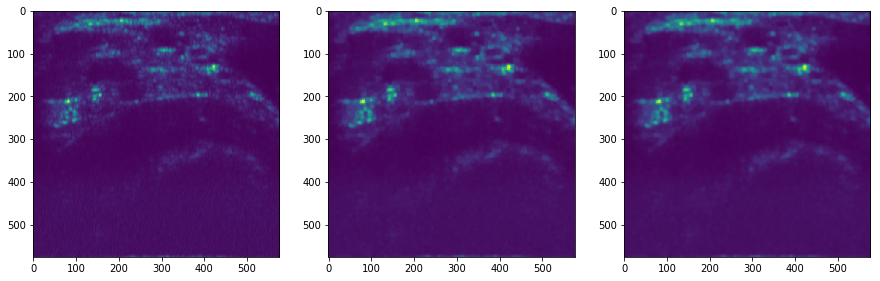

In [1348]:
im_0 = noah_wrist[0]
im_1 = noah_wrist[1]
im_0 = im_0/max_val
im_1 = im_1/max_val

im_0_opening = ndimage.morphology.grey_opening(im_0, size =(5, 5))
im_0_opening = ndimage.morphology.grey_closing(im_0_opening, size =(5, 5))


im_0_blur = gaussian_filter(im_0_opening, 1)

fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].imshow(im_0)
ax[1].imshow(im_0_opening)
ax[2].imshow(im_0_blur)

7.8
rotating 7.8 angle


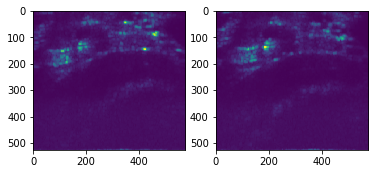

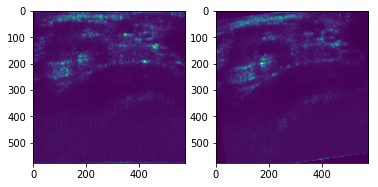

In [1374]:
im_0 = noah_wrist[1]
im_1 = noah_wrist[2]
im_0 = im_0/noah_max_val
im_1 = im_1/noah_max_val

angle = estimate_rotation(im_0, im_1, clip_top=50, conv_size = 5, gauss_filter=None)

print("rotating {} angle".format(angle))
im_2 = rotate(im_1, angle, reshape = False, order = 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(im_0)
ax[1].imshow(im_2)  

3.3
0.6
177.3
171.3
3.6
3.6
3.6
3.3
3.6
6.6
6.9
0.6
0.6
0.6
3.6
174.6
3.6
6.9
3.6
3.6


/Users/noah/Documents/CHU/Ultrasound/Ultrasound/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3.6
3.6
0.6
3.6


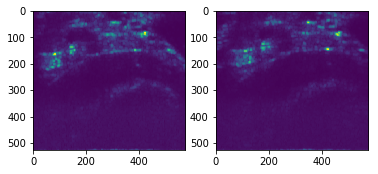

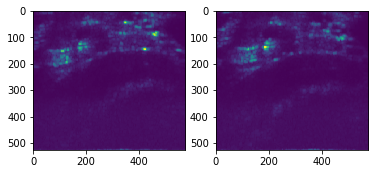

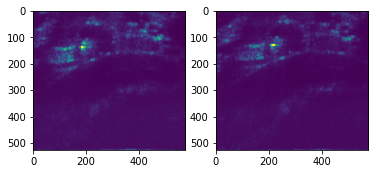

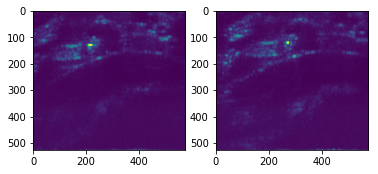

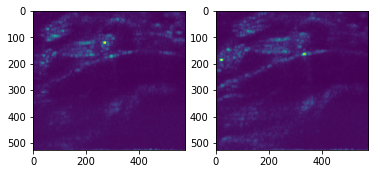

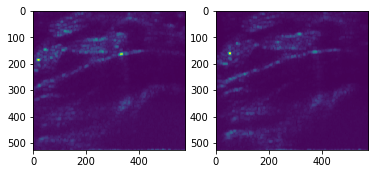

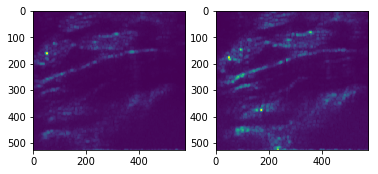

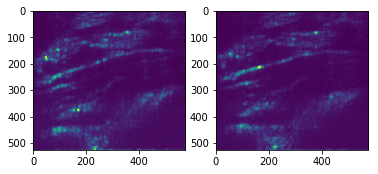

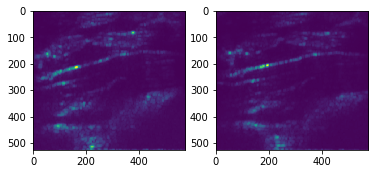

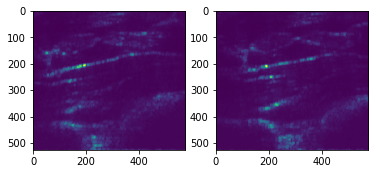

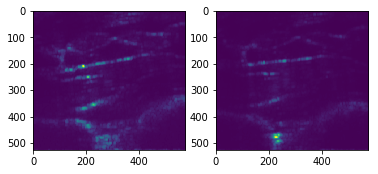

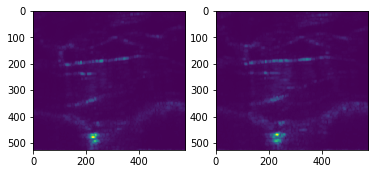

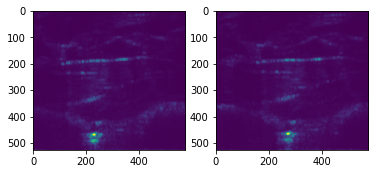

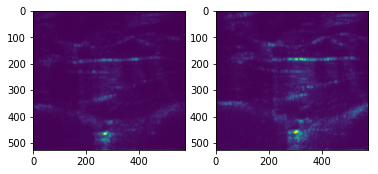

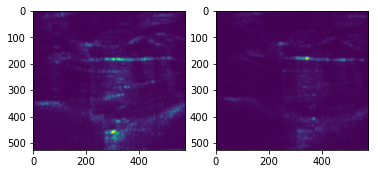

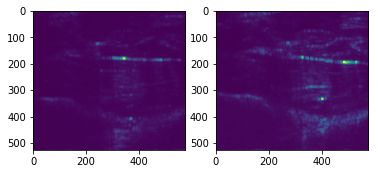

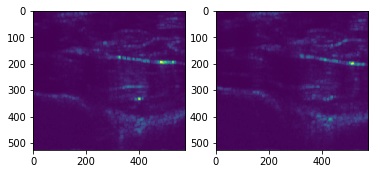

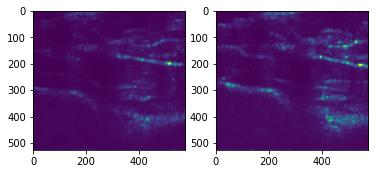

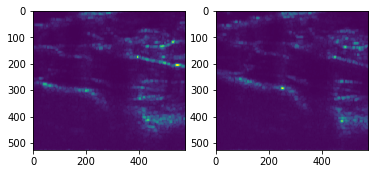

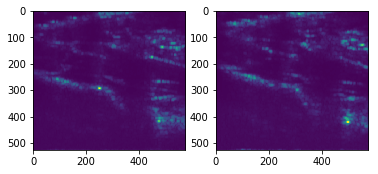

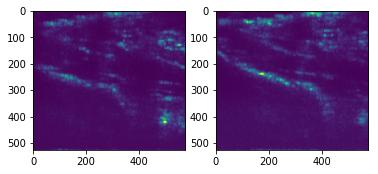

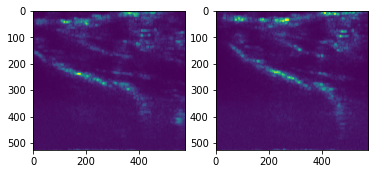

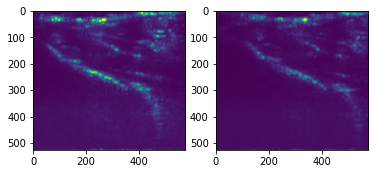

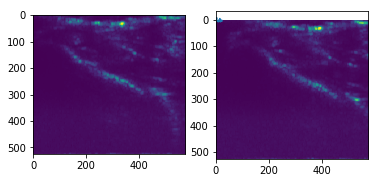

In [1378]:
angles = []

for i in range(24):
    im_0 = noah_wrist[i]
    im_1 = noah_wrist[i+1]
    im_0 = im_0/noah_max_val
    im_1 = im_1/noah_max_val

    angle = estimate_rotation(im_0, im_1, clip_top=50, conv_size = 5, gauss_filter=None)
    angles.append(angle)

plt.plot(angles)

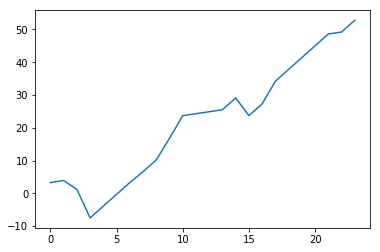

In [1379]:
plt.plot(np.cumsum(angles))

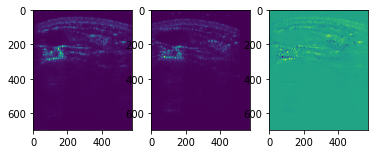

In [1311]:
t0, t1 = estimate_translation(im_0, im_2)

im_out = ndii.shift(im_2, [t0, t1])

fig, ax = plt.subplots(1,3)
ax[0].imshow(im_0)
ax[1].imshow(im_out)
ax[2].imshow(im_0-im_out)

In [737]:
def pad_if_necessary(im_0, im_1):
    '''pads im_b to size of im_0.
    throws error if size (im_0) < size(im_1).
    '''
    if im_1.shape < im_0.shape:
        print('padding')
        t = np.zeros_like(im_0)
        t[:im_1.shape[0], :im_1.shape[1]] = im_1
        im_1 = t
    
    return im_1
    

In [1390]:
def fit_images(im_a, im_b, num_iterations):
    '''aligns im_b to im_a'''
    
    rotations = np.zeros([steps])
    translations = np.zeros([steps, 2])
    errors = np.zeros([steps])

    for step in range(steps):
        print(im_a.shape)
        print(im_b.shape)

        # estimate rotation
        
        # first pad im_b if necessary to be of size im_a
        # im_b_ is a temporary array which is used for rotation estimation
        # but is not used for rotation or the size of im_a
        # would grow in an uncontrolled manner
        im_b_ = pad_if_necessary(im_a, im_b)
        
        angle = estimate_rotation(im_a, im_b_, clip_top=50, conv_size = 5, gauss_filter=None)
        
        print("rotation {}".format(angle))
        
        rotations[step]=angle
        # perform rotation, padding im_a if necessary
        im_b = rotate(im_b, angle, reshape = True, order = 1)
        im_a = pad_if_necessary(im_b, im_a) # if size(im_a)>size(im_b) no change

        # estimate translation
        im_b_ = pad_if_necessary(im_a, im_b) # pad im_b back to size of (possibly updated) im_a

        t0, t1 = estimate_translation(im_a, im_b_)
        
        print("translations {}".format([t0,t1]))
        
        # add pads to ensure entire image stays inside
        pads = np.zeros([2,2])
        if t0<0:
            pads[0,0] = -t0
        if t1<0:
            pads[1,0] = -t1
        elif t0>0:
            pads[0,1] = np.maximum(t0 - im_a.shape[0], 0)
        elif t1>0:
            pads[1,1] =  np.maximum(t1 - im_a.shape[1], 0)
        pads = pads.astype(np.int)
        
        print(pads)
        
        im_b_ = np.pad(im_b_, pads, mode ='constant')
        im_a = np.pad(im_a, pads, mode ='constant')
        
        translations[step] = [t0, t1]
        im_b_ = ndii.shift(im_b_, [t0, t1])
        
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(im_a)
        ax[1].imshow(im_b_)
        
        error = np.sum(np.power(im_a-im_b_, 2))
        errors[step] = error
    
    return im_a, im_b_, translations, rotations, errors


(288, 288)
(288, 288)
0.6
rotation 0.6
padding
translations [-1, -6]
[[1 0]
 [6 0]]
total_time 0.10326600074768066
final rotation 0.6
final translation [-1. -6.]
(2, 3)


/Users/noah/Documents/CHU/Ultrasound/Ultrasound/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


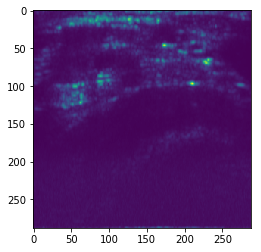

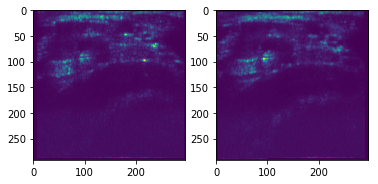

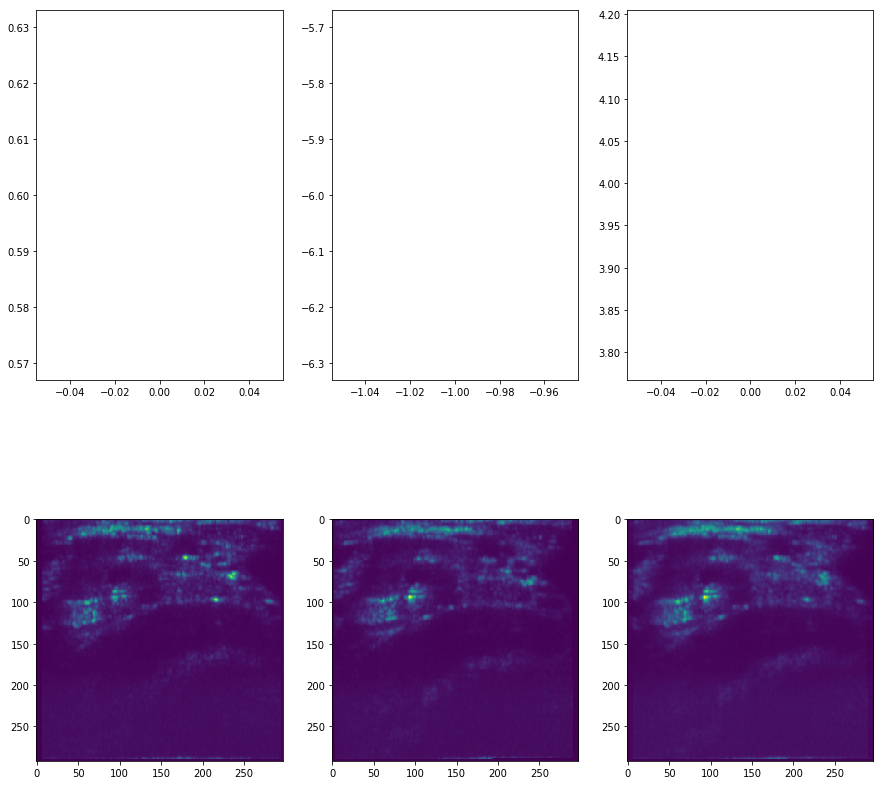

In [1391]:
im_0 = noah_wrist[1]
im_1 = noah_wrist[2]
im_0 = im_0/noah_max_val
im_1 = im_1/noah_max_val
scale = 2
im_a = resize_image(im_0,scale)
im_b = resize_image(im_1,scale)
steps = 1

plt.imshow(im_a)

time_start = time.time()
im_a, im_b, translations, rotations, errors = fit_images(im_a, im_b, steps)
print("total_time {}".format(time.time() - time_start))

print("final rotation {}".format(np.sum(rotations)))
print("final translation {}".format(np.sum(translations, axis=0)))

fig, ax = plt.subplots(2,3, figsize = (15,15))
print(ax.shape)
ax[0,0].plot(np.cumsum(rotations))
ax[0,1].plot(*np.cumsum(translations,axis=0).T)
ax[0,2].plot(errors)
ax[1,0].imshow(im_a)
ax[1,1].imshow(im_b)
ax[1,2].imshow(normalize_and_add_by_num_images([im_a,im_b]))
# test_im = normalize_and_add_by_num_images([im_a,im_b])

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00560002, ..., 0.00311498, 0.00399983,
        0.00551824],
       [0.        , 0.        , 0.00489286, ..., 0.00317983, 0.00389413,
        0.00481353],
       ...,
       [0.        , 0.        , 0.00698612, ..., 0.00360827, 0.00440489,
        0.00759358],
       [0.        , 0.        , 0.00674022, ..., 0.00337761, 0.00434536,
        0.0070602 ],
       [0.        , 0.        , 0.0062654 , ..., 0.0031932 , 0.00419307,
        0.00631986]], dtype=float32)]
(288, 288)
(288, 288)
0.6
rotation 0.6
padding
translations [1, -18]
[[ 0  0]
 [18  0]]
[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00560002, ..., 0.00311498, 0.00399983,
        0.00551824],
       [0.        , 0.        , 0.00489286, ..., 0.00317983, 0.00389413,
        0.00481353],
       ...,
       [0.        , 0. 

/Users/noah/Documents/CHU/Ultrasound/Ultrasound/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


TypeError: 'NoneType' object is not iterable

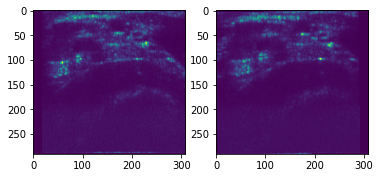

In [1399]:
base_image = noah_wrist[0]
base_image = base_image/noah_max_val
image_stack = [base_image]

print(image_stack)

scale = 2

base_image = resize_image(base_image,scale)
steps = 1

time_start = time.time()

translation_per_image = np.zeros([9,2])
rotations_per_image = np.zeros([9])

for image_iter in range(1,15):
    #fit image to base_image
    image = noah_wrist[image_iter]
    image = image/noah_max_val
    image = resize_image(image, scale)
    
    base_image, image, translations, rotations, errors = fit_images(base_image, image, steps)
    
    image_stack = image_stack.append(image)
    
    print(image_stack)
    
    base_image = normalize_and_add_by_num_images(image_stack)
    
    print("rotation {}".format(np.sum(rotations)))
    print("displacement {}".format(np.sum(translations, axis =0)))
    
print("total_time {}".format(time.time() - time_start))

plt.figure(figsize = (15,15))
plt.imshow(base_image)
    
    

In [1394]:
def normalize_and_add_by_num_images(arrs):
    '''sums a list of arrays and normalizes the resulting array
    by counting the number of non-zero values along each pixels.
    
    args:
        arrs: list of arrays to combine and normalize'''
    print(arrs)
    stacked_array = np.stack(arrs)
    summed_array = np.sum(stacked_array, axis = 0)
    
#     plt.imshow(np.sum(stacked_array>0, axis = 0 ))
    
    normalization = np.maximum(np.ones(summed_array.shape, dtype=np.int32), np.sum(stacked_array>0, axis = 0 ) )
#     plt.imshow(normalization)
#     plt.colorbar()
    return summed_array

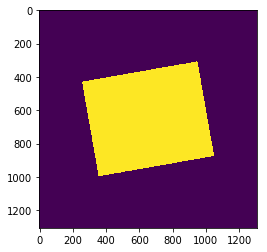

In [1075]:
im_test = data_temp[0]
im_test = np.pad(im_test, [[10,10],[10,10]], mode = "constant")
im_test = rotate(im_test, 50, order =1)
plt.imshow(im_test>0)
im_test = rotate(im_test, 50, order=1)

plt.imshow(im_test>0)
